In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
os.chdir('drive/MyDrive/SummerDO')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Data Cleaning and Processing

## LendingClub Data

In [3]:
accepted = pd.read_csv("Final Code Repo/Data/accepted_2007_to_2018Q4.csv").sample(frac = 1, axis = 0, random_state = 0).reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
accepted['loan_status'] = accepted['loan_status'].map({'Does not meet the credit policy. Status:Charged Off' : 'Charged Off',
                                                       'Does not meet the credit policy. Status:Fully Paid' : 'Fully Paid',
                                                       'Current' : 'Current', 'Fully Paid' : 'Fully Paid', 'In Grace Period' : 'In Grace Period',
                                                       'Charged Off' : 'Charged Off', 'Default' : 'Default', "Late (16-30 days)" : "Late (16-30 days)", 
                                                       "Late (31-120 days)" : "Late (31-120 days)"})
accepted['loan_status_ind'] = accepted["loan_status"].map({"Current" : -1, "Fully Paid" : 1, 
                                        "In Grace Period" : -1, "Charged Off" : 0, 
                                        "Default" : 0, "Late (16-30 days)" : 0, "Late (31-120 days)" : 0})
accepted = accepted.loc[accepted['loan_status_ind'] != -1]
accepted = accepted.loc[pd.notna(accepted['term'])]
accepted['term_y'] = [int(str(value)[:3])/12 for value in accepted['term']]
accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
accepted['month'] = pd.PeriodIndex(accepted['issue_d'], freq='M')
accepted.set_index("month", inplace = True)
accepted = accepted.sort_values(by = 'month')
accepted['issue_y'] = accepted.index.year
accepted['int_rate'] = accepted['int_rate'] / 100

In [5]:
accepted['loan_status'] = accepted['loan_status'].apply(lambda x: x if x[0:4] != 'Late' else 'Late')

In [6]:
# ANALYSIS FOR NON-DISCOUNTED RETURNS
accepted['loan_status_ind_neg'] = accepted['loan_status_ind'].replace({0:1, 1:0})

accepted['real_payoff'] = accepted['loan_amnt']*(1+accepted['int_rate']*accepted['term_y'])*(accepted['loan_status_ind']) + accepted['loan_status_ind_neg']*(accepted['total_rec_prncp'] + accepted['total_rec_int'])

accepted['real_return'] = (100*(accepted['real_payoff'] - accepted['loan_amnt'])/accepted['loan_amnt'])/accepted['term_y']

In [7]:
accepted_agg = (
    accepted
    .copy()
    .groupby(['grade', 'month']).mean()
    .reset_index()
)

accepted_agg.set_index("month", inplace = True)
accepted_agg = accepted_agg.sort_values(by = 'month')

In [8]:
accepted_diff = (
    accepted
    .copy()
    .groupby(['grade', 'month']).mean()
    .diff()
    .reset_index()
)

accepted_diff.set_index("month", inplace = True)
accepted_diff = accepted_diff.sort_values(by = 'month')

In [9]:
accepted_agg_pct = (
    accepted
    .copy()
    .groupby(['grade', 'month']).mean()
    .pct_change()
    .reset_index()
)

accepted_agg_pct.set_index("month", inplace = True)
accepted_agg_pct = accepted_agg_pct.sort_values(by = 'month')

In [10]:
accepted_log = (
    accepted
    .copy()
    .filter(['grade', 'month', 'real_return'])
    .groupby(['grade', 'month']).mean()
    .assign(return_logdiff = lambda x : np.log(x['real_return']) - np.log(x['real_return'].shift(1)))
    .reset_index()
)

accepted_log.set_index("month", inplace = True)
accepted_log = accepted_log.sort_values(by = 'month')
accepted_log = accepted_log.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Macroeconmic Trend Data

In [11]:
treasury = pd.read_csv('Final Code Repo/Data/DGS3.csv')
vix = pd.read_csv('Final Code Repo/Data/VIXCLS.csv')
inflation = pd.read_csv('Final Code Repo/Data/US_Inflation.csv')
unemployment = pd.read_csv('Final Code Repo/Data/UNRATE.csv')

In [12]:
treasury['DATE'] = pd.to_datetime(treasury['DATE'])
inflation['DATE'] = pd.to_datetime(inflation['DATE'])
unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])
vix['DATE'] = pd.to_datetime(vix['DATE'])

treasury['month'] = pd.PeriodIndex(treasury['DATE'], freq='M')
inflation['month'] = pd.PeriodIndex(inflation['DATE'], freq='M')
unemployment['month'] = pd.PeriodIndex(unemployment['DATE'], freq='M')
vix['month'] = pd.PeriodIndex(vix['DATE'], freq='M')

In [13]:
vix_q = vix.copy().groupby('month').mean().reset_index()
treasury_q = treasury.copy().groupby('month').mean().reset_index()
inflation_q = inflation.copy().groupby('month').mean().reset_index()
unemployment_q = unemployment.copy().groupby('month').mean().reset_index()

vix_q.set_index("month", inplace = True)
vix_q = vix_q.sort_values(by = 'month')
treasury_q.set_index("month", inplace = True)
treasury_q = treasury_q.sort_values(by = 'month')
inflation_q.set_index("month", inplace = True)
inflation_q = inflation_q.sort_values(by = 'month')
unemployment_q.set_index("month", inplace = True)
unemployment_q = unemployment_q.sort_values(by = 'month')

In [14]:
treasury_q_pct = treasury.copy().groupby('month').mean().pct_change().reset_index()
vix_q_pct = vix.copy().groupby('month').mean().pct_change().reset_index()
unemployment_q_pct = unemployment.copy().groupby('month').mean().pct_change().reset_index()

treasury_q_pct.set_index("month", inplace = True)
treasury_q_pct = treasury_q_pct.sort_values(by = 'month')
vix_q_pct.set_index("month", inplace = True)
vix_q_pct = vix_q_pct.sort_values(by = 'month')
unemployment_q_pct.set_index("month", inplace = True)
unemployment_q_pct = unemployment_q_pct.sort_values(by = 'month')

In [15]:
macro_trends_pct = treasury_q_pct.copy()
macro_trends_pct = macro_trends_pct.join(vix_q_pct, how='inner')
macro_trends_pct = macro_trends_pct.join(unemployment_q_pct, how='inner')

In [17]:
macro_trends = treasury_q.copy()
macro_trends = macro_trends.join(inflation_q, how='inner')
macro_trends = macro_trends.join(vix_q, how='inner')
macro_trends = macro_trends.join(unemployment_q, how='inner')

In [18]:
macro_trends_log = (
    macro_trends
    .copy()
    .assign(DGS3_logdiff = lambda x : np.log(x['DGS3']) - np.log(x['DGS3'].shift(1)))
    .assign(CPIAUCSL_logdiff = lambda x : np.log(x['CPIAUCSL']) - np.log(x['CPIAUCSL'].shift(1)))
    .assign(UNRATE_logdiff = lambda x : np.log(x['UNRATE']) - np.log(x['UNRATE'].shift(1)))
    .assign(VIXCLS_logdiff = lambda x : np.log(x['VIXCLS']) - np.log(x['VIXCLS'].shift(1)))
)

## Joint Macroeconmic and Returns Data

In [19]:
accepted_macro = (
    accepted
    .copy()
    .filter(['month', 'grade', 'loan_amnt', 'int_rate', 'term_y', 'loan_status_ind', 'real_payoff', 'real_return'])
    .join(macro_trends_log, how='inner')
)

In [20]:
accepted_3y = accepted_macro.loc[accepted_macro['term_y'] == 3].copy()
accepted_5y = accepted_macro.loc[accepted_macro['term_y'] == 5].copy()

# Plots

## Returns

Text(0.5, 1.0, 'Annual return by loan grade: monthly differences')

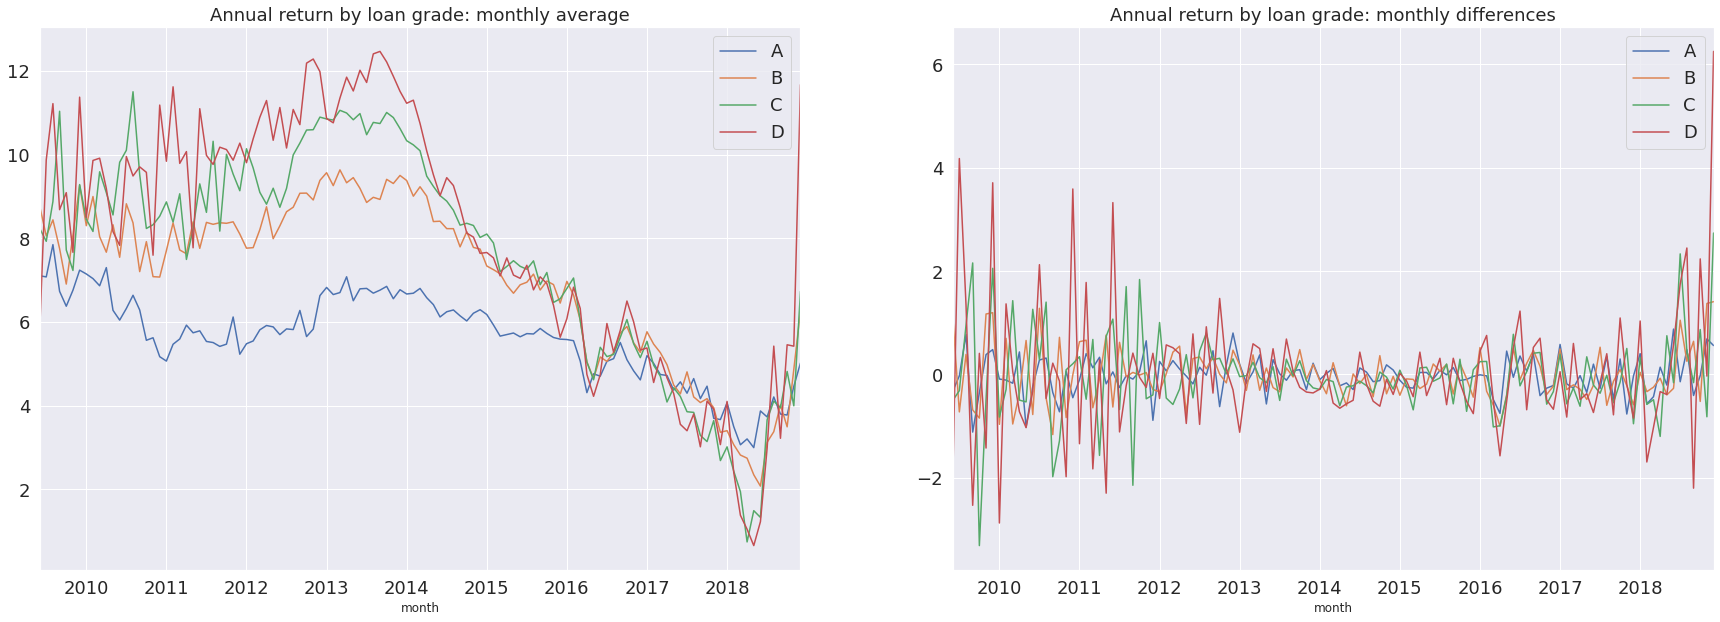

In [21]:
sns.set(rc={'figure.figsize':(30,10)})
# plt.rcParams.update({'font.size': 42})
fig, ax = plt.subplots(ncols = 2, nrows = 1)

accepted_agg.loc[accepted_agg['grade'] == 'A']['real_return'][24:].plot(ax=ax[0], label = "A")
accepted_agg.loc[accepted_agg['grade'] == 'B']['real_return'][24:].plot(ax=ax[0], label = "B")
accepted_agg.loc[accepted_agg['grade'] == 'C']['real_return'][24:].plot(ax=ax[0], label = "C")
accepted_agg.loc[accepted_agg['grade'] == 'D']['real_return'][24:].plot(ax=ax[0], label = "D")
ax[0].legend(prop={'size': 18})

accepted_diff.loc[accepted_diff['grade'] == 'A']['real_return'][24:].plot(ax=ax[1], label = "A")
accepted_diff.loc[accepted_diff['grade'] == 'B']['real_return'][24:].plot(ax=ax[1], label = "B")
accepted_diff.loc[accepted_diff['grade'] == 'C']['real_return'][24:].plot(ax=ax[1], label = "C")
accepted_diff.loc[accepted_diff['grade'] == 'D']['real_return'][24:].plot(ax=ax[1], label = "D")
ax[1].legend(prop={'size': 18})

plt.rc('axes', titlesize=18)
plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)
plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

ax[0].set_title(r"Annual return by loan grade: monthly average")
ax[1].set_title(r"Annual return by loan grade: monthly differences")

## Macroeconomic Factors

Text(0.5, 1.0, 'Macroeconomic indicators, log differences')

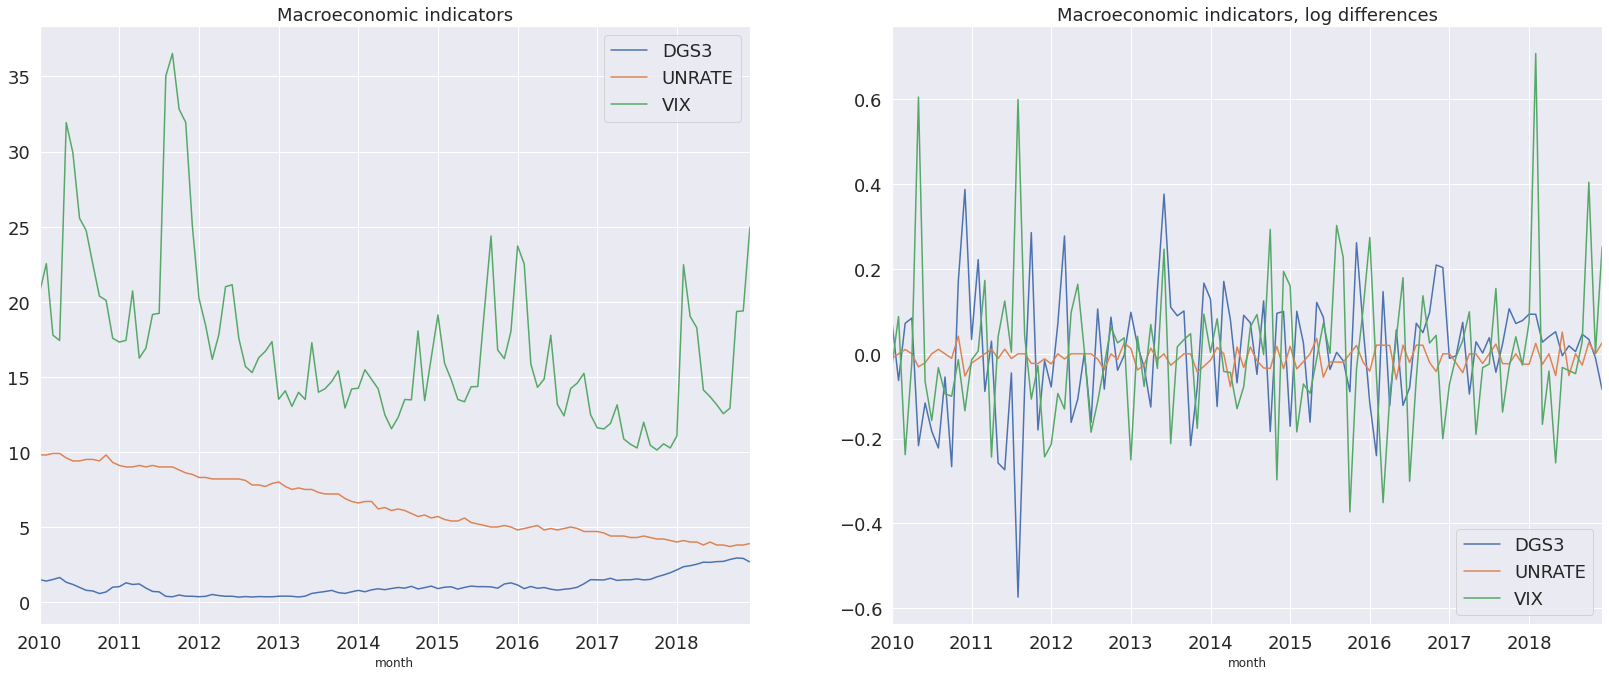

In [22]:
sns.set(rc={'figure.figsize':(28,11)})
fig, ax = plt.subplots(ncols = 2, nrows = 1)



macro_trends['DGS3'][31:].plot(ax = ax[0], label = "DGS3")
macro_trends['UNRATE'][31:].plot(ax = ax[0], label = "UNRATE")
macro_trends['VIXCLS'][31:].plot(ax = ax[0], label = "VIX")
ax[0].legend(prop={'size': 18})

macro_trends_log['DGS3_logdiff'][31:].plot(ax = ax[1], label = "DGS3")
macro_trends_log['UNRATE_logdiff'][31:].plot(ax = ax[1], label = "UNRATE")
macro_trends_log['VIXCLS_logdiff'][31:].plot(ax = ax[1], label = "VIX")
ax[1].legend(prop={'size': 18})

plt.rc('axes', titlesize=18)
plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)
plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

ax[0].set_title(r"Macroeconomic indicators")
ax[1].set_title(r"Macroeconomic indicators, log differences")

# Augmented Dickey-Fuller Tests

## ADF Test on Past Data 

In [23]:
# Differences
from statsmodels.tsa.stattools import adfuller

print('A grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_diff.loc[accepted_diff['grade'] == 'A']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('B grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_diff.loc[accepted_diff['grade'] == 'B']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('C grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_diff.loc[accepted_diff['grade'] == 'C']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('D grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_diff.loc[accepted_diff['grade'] == 'D']['real_return'][24:], maxlag=4, autolag=None))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


A grade, monthly change, stationarity test (more negative is better):
(-5.01238058207011, 2.097451944237012e-05, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
B grade, monthly change, stationarity test (more negative is better):
(-3.730570071738791, 0.00370313817534677, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
C grade, monthly change, stationarity test (more negative is better):
(-4.233117350848785, 0.0005788219024224077, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
D grade, monthly change, stationarity test (more negative is better):
(-2.889321071608033, 0.04660397886001309, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})


In [24]:
#Percent Change
from statsmodels.tsa.stattools import adfuller

print('A grade, % change, stationarity test (more negative is better):')
print(adfuller(accepted_agg_pct.loc[accepted_agg_pct['grade'] == 'A']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('B grade, % change, stationarity test (more negative is better):')
print(adfuller(accepted_agg_pct.loc[accepted_agg_pct['grade'] == 'B']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('C grade, % change, stationarity test (more negative is better):')
print(adfuller(accepted_agg_pct.loc[accepted_agg_pct['grade'] == 'C']['real_return'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('D grade, % change, stationarity test (more negative is better):')
print(adfuller(accepted_agg_pct.loc[accepted_agg_pct['grade'] == 'D']['real_return'][24:], maxlag=4, autolag=None))

# Non-stationarity rejected at 1% significance level for A, C, D.

A grade, % change, stationarity test (more negative is better):
(-4.491681538248789, 0.00020355867440804, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
B grade, % change, stationarity test (more negative is better):
(-2.177478471162186, 0.21452076650655755, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
C grade, % change, stationarity test (more negative is better):
(-4.061601889200256, 0.0011201660183769414, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})
 
 
 
D grade, % change, stationarity test (more negative is better):
(-2.833720666375066, 0.053616109059386484, 4, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852})


In [25]:
#Log

from statsmodels.tsa.stattools import adfuller

print('A grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_log.loc[accepted_log['grade'] == 'A']['return_logdiff'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('B grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_log.loc[accepted_log['grade'] == 'B']['return_logdiff'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('C grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_log.loc[accepted_log['grade'] == 'C']['return_logdiff'][24:], maxlag=4, autolag=None))
print(" ")
print(" ")
print(" ")
print('D grade, monthly change, stationarity test (more negative is better):')
print(adfuller(accepted_log.loc[accepted_log['grade'] == 'D']['return_logdiff'][24:], maxlag=4, autolag=None))

A grade, monthly change, stationarity test (more negative is better):
(-4.5685794927627015, 0.0001475354777171505, 4, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985})
 
 
 
B grade, monthly change, stationarity test (more negative is better):
(-2.566232759468639, 0.10017901066892698, 4, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673})
 
 
 
C grade, monthly change, stationarity test (more negative is better):
(-4.8197077705162945, 4.985634937388437e-05, 4, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673})
 
 
 
D grade, monthly change, stationarity test (more negative is better):
(-4.243229625376351, 0.0005562577504686561, 4, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717})


## ADF Test for Macroeconmic Indicators

In [26]:
from statsmodels.tsa.stattools import adfuller

print('DGS3 % change, stationarity test (more negative is better):')
print(adfuller(macro_trends_pct['DGS3'][31:], maxlag=8, autolag=None))
print(" ")
print(" ")
print(" ")
print('UNRATE % change, stationarity test (more negative is better):')
print(adfuller(macro_trends_pct['UNRATE'][31:], maxlag=8, autolag=None))
print(" ")
print(" ")
print(" ")
print('VIX % change, stationarity test (more negative is better):')
print(adfuller(macro_trends_pct['VIXCLS'][31:], maxlag=8, autolag=None))

# Non-stationarity rejected at 1% significance level for 8th lag

DGS3 % change, stationarity test (more negative is better):
(-4.777738855381264, 5.997731051798706e-05, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})
 
 
 
UNRATE % change, stationarity test (more negative is better):
(-3.565386504852354, 0.00645830508715636, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})
 
 
 
VIX % change, stationarity test (more negative is better):
(-4.286288489358314, 0.00046913566558362166, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})


In [27]:
from statsmodels.tsa.stattools import adfuller

print('DGS3 log diff, stationarity test (more negative is better):')
print(adfuller(macro_trends_log['DGS3_logdiff'][31:], maxlag=8, autolag=None))
print(" ")
print(" ")
print(" ")
print('UNRATE log diff, stationarity test (more negative is better):')
print(adfuller(macro_trends_log['UNRATE_logdiff'][31:], maxlag=8, autolag=None))
print(" ")
print(" ")
print(" ")
print('VIX log diff, stationarity test (more negative is better):')
print(adfuller(macro_trends_log['VIXCLS_logdiff'][31:], maxlag=8, autolag=None))

# Non-stationarity rejected at 1% significance level for 8th lag
# We will keep this

DGS3 log diff, stationarity test (more negative is better):
(-4.303442166330714, 0.0004381548157240035, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})
 
 
 
UNRATE log diff, stationarity test (more negative is better):
(-3.5583730458181124, 0.006608567585317892, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})
 
 
 
VIX log diff, stationarity test (more negative is better):
(-4.485387989680498, 0.00020894642088369321, 8, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097})


# Regressions

## 3 Year Loans

In [28]:
accepted_diff_3y = (
    accepted_3y
    .copy()
    .groupby(['grade', 'month']).mean()
    .diff()
    .reset_index()
)

accepted_diff_3y.set_index("month", inplace = True)
accepted_diff_3y = accepted_diff_3y.sort_values(by = 'month')

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# NOTE: p <= 3 to satisfy the stationarity assumption
# Look to minimize AIC => minimum MSFE
p = 1
return_regressors = [f'real_return_lag_{i}' for i in range(37, 36+p+1)]

reg_formula = 'real_return ~ real_return_lag_36'

for regressor in return_regressors:
  reg_formula += f"+ {regressor}"

In [30]:
grades = sorted(accepted['grade'].unique())
for grade in grades[0:5]:

  autoregression_df = accepted_diff_3y[accepted_diff_3y['grade']== grade][24:]
  autoregression_df = autoregression_df.filter(['grade', 'month', 'term_y','real_return'])

  for i in range(36, 36+p+1):
    autoregression_df[f'real_return_lag_{i}'] = autoregression_df['real_return'].shift(i)

  reg = sm.OLS.from_formula(reg_formula, data=autoregression_df).fit(cov_type = "HC3")
  print(grade)

  print("----------")
  print("----------")
  print("----------")
  print("----------")
  display(reg.summary())
  print("----------")
  print("----------")
  print("----------")
  print("-------")

  # alternatively
  for table in reg.summary().tables:
    print(table.as_latex_tabular())
# Statistically significant coefficients for A and C grades

A
----------
----------
----------
----------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            real_return   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.197
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.308
Time:                        20:04:23   Log-Likelihood:                -22.718
No. Observations:                  78   AIC:                             51.44
Df Residuals:                      75   BIC:                             58.51
Df Model:                           2                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0046      0.038     -0.119      0.905      -0.080       0.070
real_return_lag_36     0.0490      0.129      0.380      0.704      -0.204       0.302
real_return_lag_37     0.1909      0.124      1.545      0.122      -0.051       0.433
==============================================================================
Omnibus:                        1.341   Durbin-Watson:                   2.396
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                0.905
Skew:                           0.254   Prob(JB):                        0.636
Kurtosis:                       3.141   Cond. No.                         3.38
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   real\_return   & \textbf{  R-squared:         } &    0.036  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.011  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    1.197  \\
\textbf{Date:}             & Sun, 24 Jul 2022 & \textbf{  Prob (F-statistic):} &   0.308   \\
\textbf{Time:}             &     20:04:23     & \textbf{  Log-Likelihood:    } &  -22.718  \\
\textbf{No. Observations:} &          78      & \textbf{  AIC:               } &    51.44  \\
\textbf{Df Residuals:}     &          75      & \textbf{  BIC:               } &    58.51  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &       HC3        & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{ce

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            real_return   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6.357
Date:                Sun, 24 Jul 2022   Prob (F-statistic):            0.00282
Time:                        20:04:23   Log-Likelihood:                -38.806
No. Observations:                  78   AIC:                             83.61
Df Residuals:                      75   BIC:                             90.68
Df Model:                           2                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0404      0.047     -0.863      0.388      -0.132       0.051
real_return_lag_36    -0.0887      0.080     -1.114      0.265      -0.245       0.067
real_return_lag_37     0.1385      0.078      1.787      0.074      -0.013       0.290
==============================================================================
Omnibus:                        5.080   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.632
Skew:                           0.272   Prob(JB):                       0.0599
Kurtosis:                       4.199   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   real\_return   & \textbf{  R-squared:         } &    0.064  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.039  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    6.357  \\
\textbf{Date:}             & Sun, 24 Jul 2022 & \textbf{  Prob (F-statistic):} & 0.00282   \\
\textbf{Time:}             &     20:04:23     & \textbf{  Log-Likelihood:    } &  -38.806  \\
\textbf{No. Observations:} &          78      & \textbf{  AIC:               } &    83.61  \\
\textbf{Df Residuals:}     &          75      & \textbf{  BIC:               } &    90.68  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &       HC3        & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{ce

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            real_return   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     2.415
Date:                Sun, 24 Jul 2022   Prob (F-statistic):             0.0963
Time:                        20:04:23   Log-Likelihood:                -80.438
No. Observations:                  78   AIC:                             166.9
Df Residuals:                      75   BIC:                             173.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0308      0.078     -0.394      0.694      -0.184       0.122
real_return_lag_36     0.1213      0.059      2.057      0.040       0.006       0.237
real_return_lag_37    -0.0159      0.071     -0.225      0.822      -0.154       0.122
==============================================================================
Omnibus:                       51.982   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.176
Skew:                           1.836   Prob(JB):                     4.04e-71
Kurtosis:                      12.288   Cond. No.                         1.41
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   real\_return   & \textbf{  R-squared:         } &    0.026  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &   -0.000  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    2.415  \\
\textbf{Date:}             & Sun, 24 Jul 2022 & \textbf{  Prob (F-statistic):} &  0.0963   \\
\textbf{Time:}             &     20:04:23     & \textbf{  Log-Likelihood:    } &  -80.438  \\
\textbf{No. Observations:} &          78      & \textbf{  AIC:               } &    166.9  \\
\textbf{Df Residuals:}     &          75      & \textbf{  BIC:               } &    173.9  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &       HC3        & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{ce

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            real_return   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.5648
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.571
Time:                        20:04:23   Log-Likelihood:                -128.77
No. Observations:                  78   AIC:                             263.5
Df Residuals:                      75   BIC:                             270.6
Df Model:                           2                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0079      0.148      0.053      0.957      -0.282       0.298
real_return_lag_36    -0.0901      0.094     -0.958      0.338      -0.274       0.094
real_return_lag_37    -0.0878      0.091     -0.963      0.335      -0.266       0.091
==============================================================================
Omnibus:                       74.491   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.225
Skew:                           2.683   Prob(JB):                    2.38e-185
Kurtosis:                      18.258   Cond. No.                         1.92
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   real\_return   & \textbf{  R-squared:         } &    0.013  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &   -0.013  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &   0.5648  \\
\textbf{Date:}             & Sun, 24 Jul 2022 & \textbf{  Prob (F-statistic):} &   0.571   \\
\textbf{Time:}             &     20:04:23     & \textbf{  Log-Likelihood:    } &  -128.77  \\
\textbf{No. Observations:} &          78      & \textbf{  AIC:               } &    263.5  \\
\textbf{Df Residuals:}     &          75      & \textbf{  BIC:               } &    270.6  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &       HC3        & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{ce

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            real_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.1131
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.893
Time:                        20:04:23   Log-Likelihood:                -152.58
No. Observations:                  78   AIC:                             311.2
Df Residuals:                      75   BIC:                             318.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0249      0.200     -0.125      0.901      -0.416       0.366
real_return_lag_36    -0.0075      0.063     -0.119      0.906      -0.131       0.116
real_return_lag_37    -0.0218      0.046     -0.476      0.634      -0.112       0.068
==============================================================================
Omnibus:                        2.902   Durbin-Watson:                   2.569
Prob(Omnibus):                  0.234   Jarque-Bera (JB):                2.667
Skew:                           0.072   Prob(JB):                        0.263
Kurtosis:                       3.895   Cond. No.                         4.11
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   real\_return   & \textbf{  R-squared:         } &    0.002  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &   -0.025  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &   0.1131  \\
\textbf{Date:}             & Sun, 24 Jul 2022 & \textbf{  Prob (F-statistic):} &   0.893   \\
\textbf{Time:}             &     20:04:23     & \textbf{  Log-Likelihood:    } &  -152.58  \\
\textbf{No. Observations:} &          78      & \textbf{  AIC:               } &    311.2  \\
\textbf{Df Residuals:}     &          75      & \textbf{  BIC:               } &    318.2  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &       HC3        & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{ce

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# NOTE: p <= 3 to satisfy the stationarity assumption
p = 3
# NOTE: q <= 8 to satisfy the stationarity assumption
q = 1
VIX_regressors = [f'VIXCLS_logdiff_lag_{i}' for i in range(1, q+1)]
DGS3_regressors = [f'DGS3_logdiff_lag_{i}' for i in range(1, q+1)]
CPI_regressors = [f'CPIAUCSL_logdiff_lag_{i}' for i in range(1, q+1)]
UNRATE_regressors = [f'UNRATE_logdiff_lag_{i}' for i in range(1, q+1)]
return_regressors = [f'real_return_lag_{i}' for i in range(37, 36+p+1)]

reg_formula = 'real_return ~ real_return_lag_36'

for regressor in return_regressors:
  reg_formula += f"+ {regressor}"

for regressor in DGS3_regressors:
  reg_formula += f"+ {regressor}"

for regressor in VIX_regressors:
  reg_formula += f"+ {regressor}"

# for regressor in CPI_regressors:
#   reg_formula += f"+ {regressor}"

for regressor in UNRATE_regressors:
  reg_formula += f"+ {regressor}"


####################################
#                                  #
# MINIMUM AIC PARAMETERS:          #
#                                  #
# A: p=1, q=5 (predictable)        #
#                                  #
# B: p=3, q=4 (unpredictable)      #
#                                  #
# C: p=3, q=1 (predictable)        #
#                                  #
# D: p=3, q=1 (predictable)        #
#                                  #
# E: p=3, q=1 (unpredictable)      #
#                                  #
####################################

In [38]:
from importlib import invalidate_caches
# Define function to output plot of the model coefficients

def coefplot(results, grade):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    coef_df['signf'] = [0 if np.sign(coef_df['[0.025'][i]) == np.sign(coef_df['0.975]'][i]) else 1 for i in range(coef_df.shape[0])]
        
    # Append errors column to dataframe
    print(errors)
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['Intercept'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables

    coef_df = coef_df.sort_values(by = 'variables')
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    colors = ["steelblue" if i == 1 else "red" for i in coef_df['signf'].values]

    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='#FF000000', fontsize=22, 
                 ecolor=colors, capsize=0,
                 yerr='errors',xerr = None, legend=False, visible= False)
    
    # Set title & labels
    ax.set_title(f'{grade}-grade regression coefficients w/ 95% confidence intervals',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)

    ax.tick_params(labelsize = 18)

    # sns.set(style="ticks") 
    
    # # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color=colors)
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)

    # ax.set_ylim(-3, 1.5)
    
    plt.savefig(f"{grade}_reg.png")
    
    return plt.show()


Intercept               0.2892
real_return_lag_36      0.2824
real_return_lag_37      0.2590
real_return_lag_38      0.1915
real_return_lag_39      0.2016
DGS3_logdiff_lag_1      1.4599
VIXCLS_logdiff_lag_1    1.5288
UNRATE_logdiff_lag_1    6.6344
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


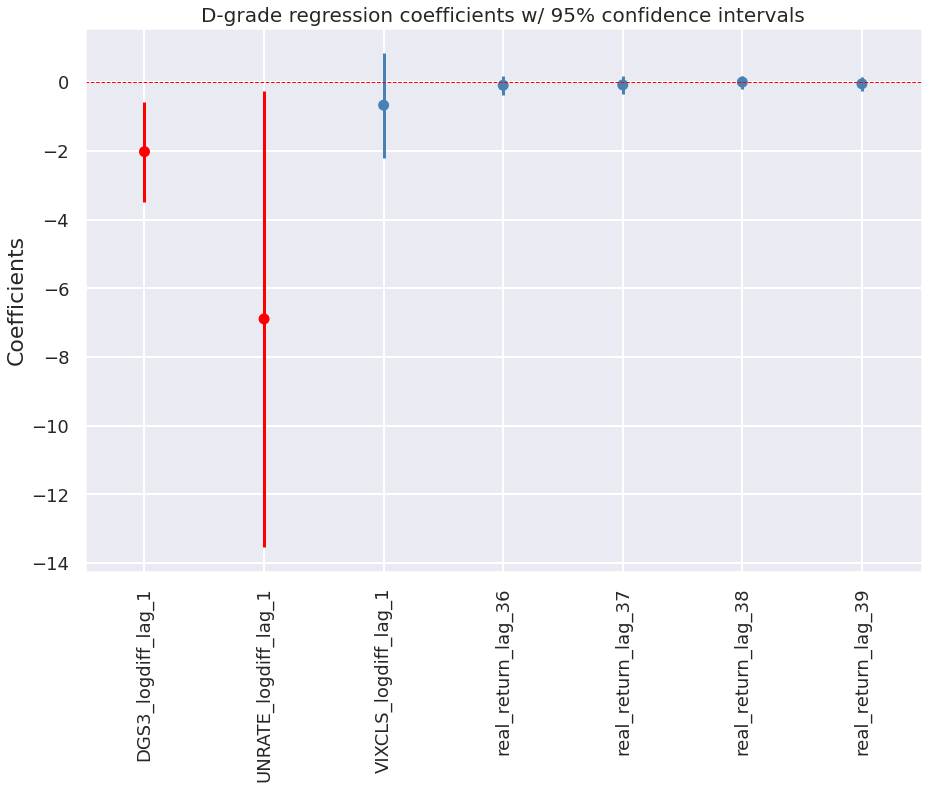

In [33]:
grades = sorted(accepted['grade'].unique())
for grade in grades[0:5]:

  regression_df = accepted_diff_3y[accepted_diff_3y['grade']== grade][24:]
  regression_df = regression_df.filter(['grade', 'month', 'term_y','real_return', 'DGS3_logdiff', 'VIXCLS_logdiff', 'UNRATE_logdiff'])

  for i in range(36, 36+p+1):
    regression_df[f'real_return_lag_{i}'] = regression_df['real_return'].shift(i)

  for i in range(1, q+1):    
    regression_df[f'DGS3_logdiff_lag_{i}'] = regression_df[f'DGS3_logdiff'].shift(i)

  for i in range(1, q+1):
    # regression_df[f'CPIAUCSL_logdiff_lag_{i}'] = regression_df[f'CPIAUCSL_logdiff'].shift(i)
    regression_df[f'VIXCLS_logdiff_lag_{i}'] = regression_df[f'VIXCLS_logdiff'].shift(i)
    regression_df[f'UNRATE_logdiff_lag_{i}'] = regression_df[f'UNRATE_logdiff'].shift(i)

  reg = sm.OLS.from_formula(reg_formula, data=regression_df).fit(cov_type = "HC3")

  
  # plt.rc("figure", figsize=(10, 15))

  if grade == "D":
    coefplot(reg, grade)

    # print(grade)
    # print("----------")
    # print("----------")
    # print("----------")
    # print("----------")
    # display(reg.summary())
    # print("----------")
    # print("----------")
    # print("----------")
    # print("-------")

    # alternatively
  # for table in reg.summary().tables:
  #   print(table.as_latex_tabular())
  
# Statistically significant coefficients for A, C, D, E grades

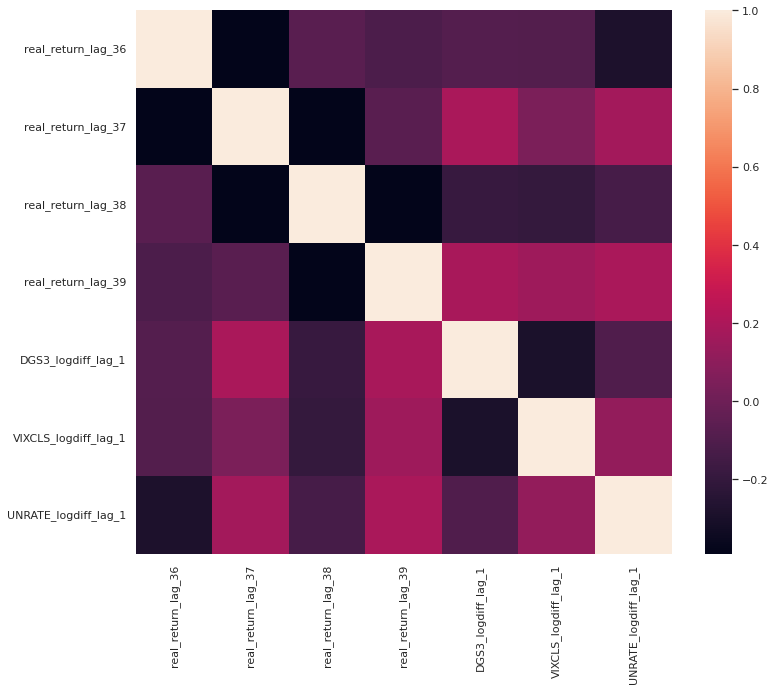

In [35]:
sns.set(rc={'figure.figsize':(12,10)})
regression_df = regression_df.drop(['term_y', 'DGS3_logdiff', 'UNRATE_logdiff', 'VIXCLS_logdiff', 'real_return'], axis=1)
sns.heatmap(regression_df.corr())
# No significant multicollinearity

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

reg_formula = 'real_return_std ~ DGS3_logdiff + CPIAUCSL_logdiff + VIXCLS_logdiff + UNRATE_logdiff + resign_ind'
accepted_diff_3y['real_return_std'] = accepted_diff_3y['real_return'].rolling(10).std()

In [37]:
grades = sorted(accepted['grade'].unique())
for grade in grades[0:5]:

  regression_df = accepted_diff_3y[accepted_diff_3y['grade']== grade][24:]
  regression_df = regression_df.filter(['grade', 'month', 'term_y','real_return_std', 'DGS3_logdiff', 'CPIAUCSL_logdiff', 'VIXCLS_logdiff', 'UNRATE_logdiff'])
  regression_df.loc[:78, 'resign_ind'] = 0
  regression_df.loc[78:, 'resign_ind'] = 1

  reg = sm.OLS.from_formula(reg_formula, data=regression_df).fit(cov_type = "HC3")
  print(grade)
  print("----------")
  print("----------")
  print("----------")
  print("----------")
  display(reg.summary())
  print("----------")
  print("----------")
  print("----------")
  print("-------")
# Statistically significant coefficients for A, C, D, E grades

A
----------
----------
----------
----------


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        real_return_std   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.3220
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.899
Time:                        20:04:46   Log-Likelihood:                -337.21
No. Observations:                 115   AIC:                             686.4
Df Residuals:                     109   BIC:                             702.9
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.7514      0.505     11.395      0.000       4.762       6.741
DGS3_logdiff        -1.4016      2.031     -0.690      0.490      -5.383       2.579
CPIAUCSL_logdiff  -142.1206    185.369     -0.767      0.443    -505.438     221.197
VIXCLS_logdiff      -0.2098      1.918     -0.109      0.913      -3.969       3.549
UNRATE_logdiff       2.7058     16.806      0.161      0.872     -30.234      35.646
resign_ind          -0.5993      1.035     -0.579      0.563      -2.628       1.430
==============================================================================
Omnibus:                       51.078   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.169
Skew:                           1.806   Prob(JB):                     1.33e-26
Kurtosis:                       6.439   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
B
----------
----------
----------
----------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        real_return_std   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4499
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.813
Time:                        20:04:46   Log-Likelihood:                -333.96
No. Observations:                 115   AIC:                             679.9
Df Residuals:                     109   BIC:                             696.4
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4903      0.556      9.878      0.000       4.401       6.580
DGS3_logdiff        -2.9522      2.690     -1.097      0.272      -8.225       2.320
CPIAUCSL_logdiff   -32.9232    180.127     -0.183      0.855    -385.966     320.119
VIXCLS_logdiff      -1.0662      2.291     -0.465      0.642      -5.557       3.425
UNRATE_logdiff      -8.2691     12.430     -0.665      0.506     -32.631      16.093
resign_ind          -0.7269      0.891     -0.816      0.415      -2.474       1.020
==============================================================================
Omnibus:                       46.370   Durbin-Watson:                   0.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.980
Skew:                           1.748   Prob(JB):                     1.06e-20
Kurtosis:                       5.640   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
C
----------
----------
----------
----------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        real_return_std   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3814
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.861
Time:                        20:04:46   Log-Likelihood:                -333.62
No. Observations:                 115   AIC:                             679.2
Df Residuals:                     109   BIC:                             695.7
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.5991      0.515     10.867      0.000       4.589       6.609
DGS3_logdiff        -1.7185      2.481     -0.693      0.489      -6.582       3.145
CPIAUCSL_logdiff   -87.2068    167.504     -0.521      0.603    -415.508     241.095
VIXCLS_logdiff      -0.6571      2.080     -0.316      0.752      -4.734       3.419
UNRATE_logdiff      -0.5244     16.226     -0.032      0.974     -32.328      31.279
resign_ind          -0.9264      0.963     -0.962      0.336      -2.815       0.962
==============================================================================
Omnibus:                       45.240   Durbin-Watson:                   0.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.093
Skew:                           1.689   Prob(JB):                     2.73e-20
Kurtosis:                       5.717   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
D
----------
----------
----------
----------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        real_return_std   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.3695
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.869
Time:                        20:04:46   Log-Likelihood:                -323.99
No. Observations:                 115   AIC:                             660.0
Df Residuals:                     109   BIC:                             676.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.6343      0.464     12.135      0.000       4.724       6.544
DGS3_logdiff        -1.8817      1.988     -0.947      0.344      -5.778       2.015
CPIAUCSL_logdiff   -42.6339    153.663     -0.277      0.781    -343.808     258.541
VIXCLS_logdiff       0.1034      1.729      0.060      0.952      -3.285       3.491
UNRATE_logdiff      -4.4146     13.183     -0.335      0.738     -30.252      21.423
resign_ind          -0.7550      0.895     -0.844      0.399      -2.509       0.999
==============================================================================
Omnibus:                       35.733   Durbin-Watson:                   0.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.199
Skew:                           1.456   Prob(JB):                     2.30e-13
Kurtosis:                       4.915   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
E
----------
----------
----------
----------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        real_return_std   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                    0.8158
Date:                Sun, 24 Jul 2022   Prob (F-statistic):              0.541
Time:                        20:04:46   Log-Likelihood:                -329.14
No. Observations:                 115   AIC:                             670.3
Df Residuals:                     109   BIC:                             686.8
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.4633      0.490     11.146      0.000       4.503       6.424
DGS3_logdiff        -4.1001      2.294     -1.787      0.074      -8.597       0.397
CPIAUCSL_logdiff   -34.6705    163.015     -0.213      0.832    -354.175     284.834
VIXCLS_logdiff      -1.9236      2.100     -0.916      0.360      -6.040       2.193
UNRATE_logdiff     -13.0028     12.904     -1.008      0.314     -38.294      12.288
resign_ind          -0.5616      0.939     -0.598      0.550      -2.403       1.280
==============================================================================
Omnibus:                       46.013   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.490
Skew:                           1.675   Prob(JB):                     1.12e-21
Kurtosis:                       5.985   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

----------
----------
----------
-------
